# Test fitting time of MLE fitting

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import unittest
import numpy as np
import multiprocessing as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from aind_dynamic_foraging_models.generative_model.agent_q_learning import forager_Hattori2019
from aind_behavior_gym.dynamic_foraging.task.coupled_block_task import CoupledBlockTask
from aind_dynamic_foraging_basic_analysis import plot_foraging_session

#### Set up agent and generate simulated data

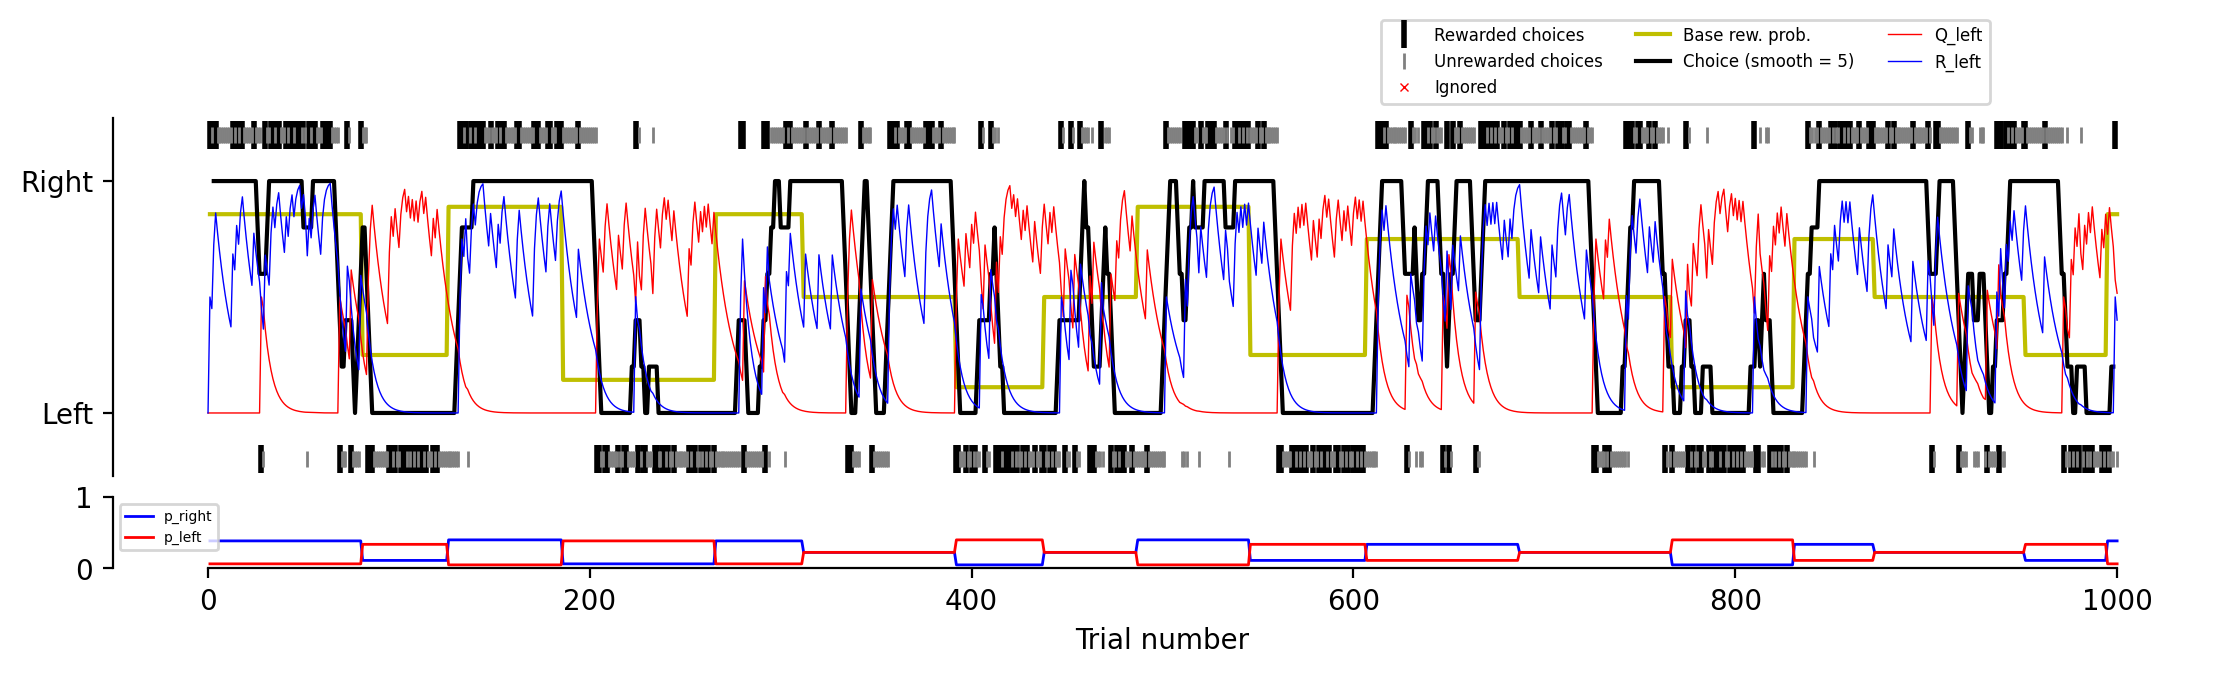

In [2]:
forager = forager_Hattori2019(
    dict(
        softmax_inverse_temperature=5,
        biasL=0,
    ),
    seed=42,
)
task = CoupledBlockTask(
    reward_baiting=True, 
    num_trials=1000, 
    seed=42
    )

forager.perform(task)
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
fig, axes = forager.plot_session()


#### Perform the task

In [3]:
def time_fitting(DE_workers):
    start_time = time.time()
    forager = forager_Hattori2019()  # To fit a model, just create a new forager
    forager.fit(
        choice_history,
        reward_history,
        fit_bounds_override={"softmax_inverse_temperature": [0, 100]},
        clamp_params={"biasL": 0},
        DE_workers=DE_workers,
    )
    end_time = time.time()
    
    fitting_result = forager.fitting_result
    assert fitting_result.success
    np.testing.assert_array_almost_equal(
        fitting_result.x, [0.6010, 0.1087, 0.1544, 4.8908], decimal=2
    )
    fit_time = end_time - start_time
    print(f'Fitting time, DE_workers = {DE_workers}: {fit_time} s')
    return fit_time, forager

In [4]:
num_cpu_to_test = [8, 16]
runs = 2
times = np.full((len(num_cpu_to_test), runs), np.nan)

for n, num_cpu in enumerate(tqdm(num_cpu_to_test)):
    for i, run in enumerate(tqdm(range(runs))):
        times[n, i], forager = time_fitting(num_cpu)

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting time, DE_workers = 8: 21.037405967712402 s


Text(0, 0.5, 'Fitting time (s)')

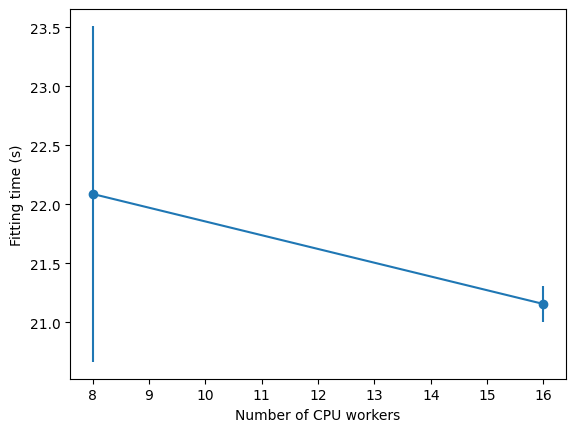

In [ ]:
# Plot fitting times
plt.figure()
plt.errorbar(num_cpu_to_test, np.mean(times, axis=1), yerr=np.std(times, axis=1), fmt='o-')
plt.xlabel('Number of CPU workers')
plt.ylabel('Fitting time (s)')

No fitting result found. Please fit the model first.


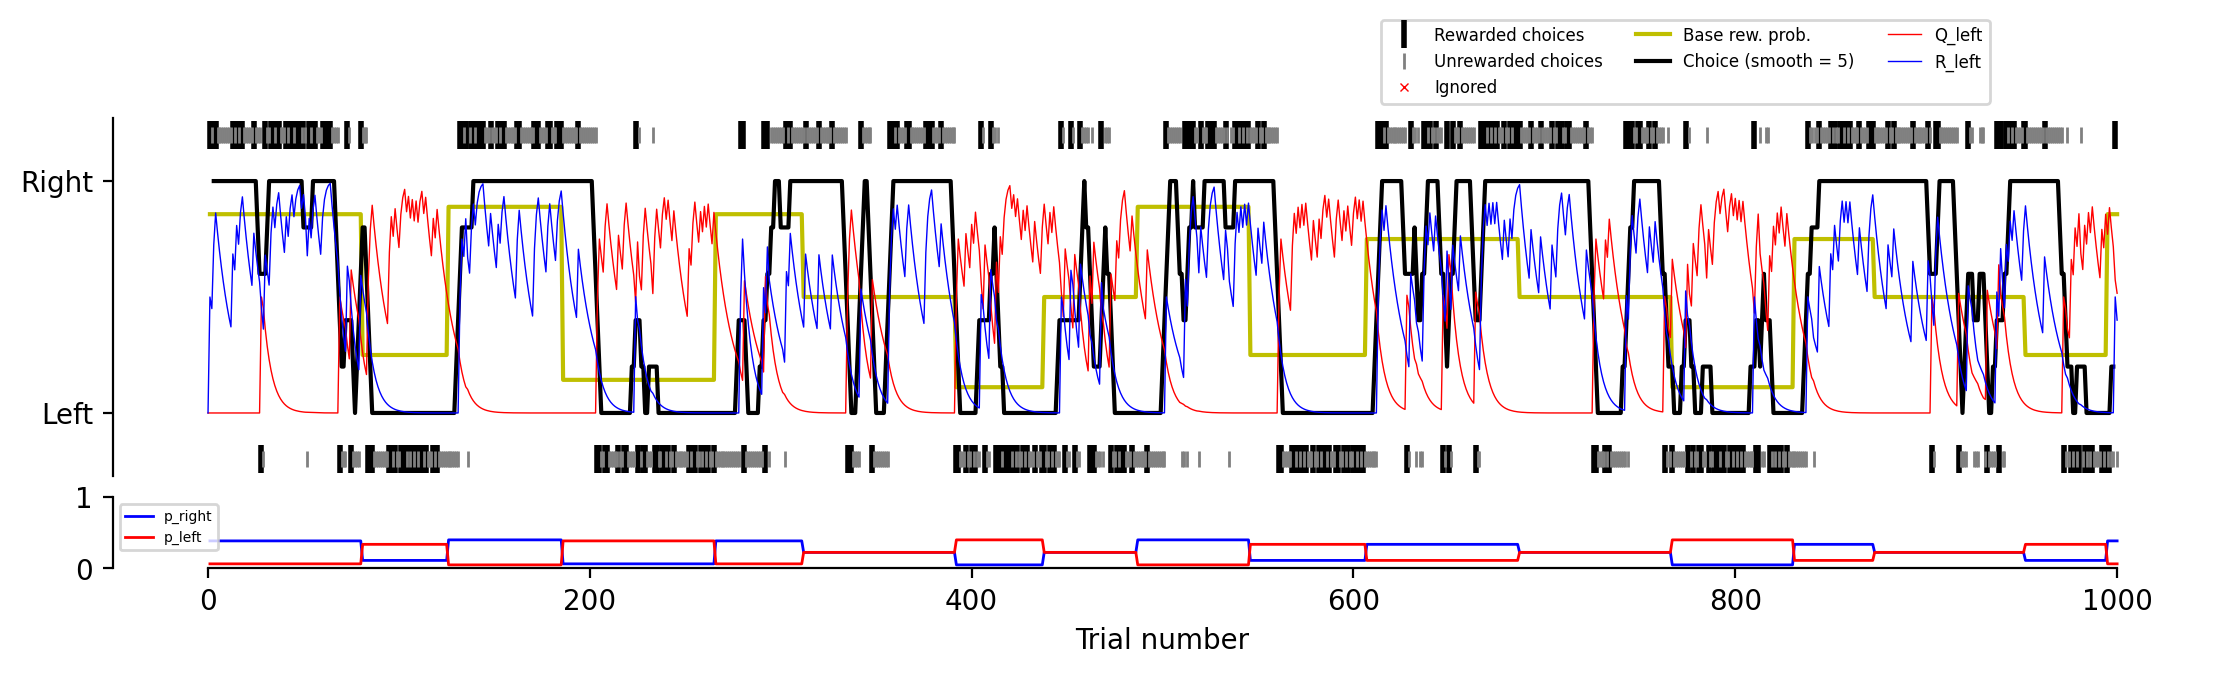

In [ ]:
forager.plot_fitted_latent_variables(axes[0])
fig